In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import matplotlib.pyplot as plt 

In [62]:
import numpy as np
import cv2
import torch
import torch.nn.functional as F

# from torchvision.models.optical_flow import Raft_Large_Weights
# from torchvision.models.optical_flow import raft_large
from torchvision.utils import flow_to_image
import torchvision.transforms as T
# import kornia.geometry.transform as kg

from glob import glob
# import matplotlib.pyplot as plt
import numpy as np
# import imageio.v3 as io
from PIL import Image
from tqdm import tqdm
import cv2
import einops
# from skimage import restoration, img_as_float
# from scipy.signal import gaussian
from torchvision.transforms import functional as TF

import cv2 as cv
import ptlflow
from ptlflow.utils import flow_utils

In [63]:
import cv2 as cv
import ptlflow
from ptlflow.utils import flow_utils
from ptlflow.utils.io_adapter import IOAdapter
# import matplotlib.pyplot as plt
import torch
from PIL import Image
import os
import pandas as pd

import torch
import numpy as np
from glob import glob
# import matplotlib.pyplot as plt
from Getflow import load_images, load_images_gray , getFlowMask, getFlowMaskGlobal, getFlowMask_other

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [65]:
def normalization(data):
    _range = torch.max(data) - torch.min(data)
    return (data - torch.min(data)) / _range

def load_flow_tensor(flow, scale=1, normalize=True, align_corners=True):
    """
    Load flow, scale the pixel values according to the resized scale.
    If normalize is true, return rescaled in normalized pixel coordinates
    where pixel coordinates are in range [-1, 1].
    NOTE: RAFT USES ALIGN_CORNERS=TRUE SO WE NEED TO ACCOUNT FOR THIS
    Returns (2, H, W) float32
    """
    # flow = read_flo(path).astype(np.float32)
    H, W, _ = flow.shape
    u, v = flow[..., 0], flow[..., 1]
    if normalize:
        if align_corners:
            u = 2.0 * u / (W - 1)
            v = 2.0 * v / (H - 1)
        else:
            u = 2.0 * u / W
            v = 2.0 * v / H
    else:
        u = scale * u
        v = scale * v

    if scale != 1:
        h, w = int(scale * H), int(scale * W)
        u = Image.fromarray(u).resize((w, h), Image.ANTIALIAS)
        v = Image.fromarray(v).resize((w, h), Image.ANTIALIAS)
        u, v = np.array(u), np.array(v)
    return torch.from_numpy(np.stack([u, v], axis=0))

def get_uv_grid(H, W, homo=False, align_corners=False, device=None):
    """
    Get uv grid renormalized from -1 to 1
    :returns (H, W, 2) tensor
    """
    if device is None:
        device = torch.device("cpu")
    yy, xx = torch.meshgrid(
        torch.arange(H, dtype=torch.float32, device=device),
        torch.arange(W, dtype=torch.float32, device=device),
        indexing="ij",
    )
    if align_corners:
        xx = 2 * xx / (W - 1) - 1
        yy = 2 * yy / (H - 1) - 1
    else:
        xx = 2 * (xx + 0.5) / W - 1
        yy = 2 * (yy + 0.5) / H - 1
    if homo:
        return torch.stack([xx, yy, torch.ones_like(xx)], dim=-1)
    return torch.stack([xx, yy], dim=-1)

def compute_sampson_error(x1, x2, F):
    """
    :param x1 (*, N, 2)
    :param x2 (*, N, 2)
    :param F (*, 3, 3)
    """
    h1 = torch.cat([x1, torch.ones_like(x1[..., :1])], dim=-1)
    h2 = torch.cat([x2, torch.ones_like(x2[..., :1])], dim=-1)
    d1 = torch.matmul(h1, F.transpose(-1, -2))  # (B, N, 3)
    d2 = torch.matmul(h2, F)  # (B, N, 3)
    z = (h2 * d1).sum(dim=-1)  # (B, N)
    err = z ** 2 / (
        d1[..., 0] ** 2 + d1[..., 1] ** 2 + d2[..., 0] ** 2 + d2[..., 1] ** 2
    )
    return err

In [66]:
of_methods = {
                # "craft":"things",
                # "craft":"sintel",
                # "craft":"kitti",
                # "csflow":"chairs",
                # "csflow":"things",
                # "csflow":"kitti",
                # "gmflow":"chairs",
                # "gmflow":"things",
                # "gmflow":"kitti",
                # "gmflow":"sintel",
                # "gmflownet_mix":"sintel",
                # "flowformer":"sintel",
                "gma":"sintel",
}

In [67]:
of_ckpt_list=[]
for of, ckpt in of_methods.items():
    of_ckpt_list.append(of+' '+'with'+' '+ckpt)

In [68]:
of_ckpt_list

['gma with sintel']

In [69]:
video_name_list = [
                    # 'Single_Car',
                    'Car_on_Apache',
                    # 'Person_Walking_with_umbrella',
                    # 'pickup_truck_extreme_turbulence',
                    # 'Large_white_car',
                    # 'woman_walking_camera_drift',
                    'White_car_stop_sign',
                    # 'Turbulence_on_Highway',
                    # 'person_running_with_umbrella',
                    # 'moving_electric_scooter_and_car',
                    # 'Full_Aeroplane',
                    # 'Anothre_Single_Car',
                    # 'Two_student_walking_MU1',
                    # 'scooter_road_crossing',
                    # 'bird_behind_piller',
                    # 'Second_walking_person',
                    # 'Zoomed_Aeroplane',
                    # 'person_behind_walk_only_zone',
                    # 'Pickup_track',
                    # 'Blue_Car',
                    # 'person_with_scooter',
                    # 'car-shadow',
                    'tennis',
                    'surf'
    
]

In [70]:
filePath = '/zfs/ailab/dehaoq/eccv2024/data'
IMG_DIR = '/zfs/ailab/dehaoq/eccv2024/data/White_car_stop_signc'
FLOW_DIR = '/zfs/ailab/dehaoq/eccv2024/flow/White_car_stop_sign'
FLOW_GAP1 = '/zfs/ailab/dehaoq/eccv2024/flow/White_car_stop_sign/gap=1'
FLOW_GAP2 = '/zfs/ailab/dehaoq/eccv2024/flow/White_car_stop_sign/gap=2'
FLOW_GAP3 = '/zfs/ailab/dehaoq/eccv2024/flow/White_car_stop_sign/gap=3'
FLOW_GAP4 = '/zfs/ailab/dehaoq/eccv2024/flow/White_car_stop_sign/gap=4'
# FLOW_GAP1_FOR = 

In [71]:
from glob import glob
import os

In [72]:
if not os.path.exists(FLOW_DIR):
    os.makedirs(FLOW_DIR) 

In [73]:
imgList = sorted(glob(f'{IMG_DIR}/*'))

In [74]:
for img_id in range(len(imgList)):
    img_center = cv2.imread(os.path.join(IMG_DIR, f"{img_id:05d}.png"))

In [75]:
IMG_DIR = '/zfs/ailab/dehaoq/eccv2024/data/Car_shadow_2.50'

In [76]:
FLOW_DIR = '/zfs/ailab/dehaoq/eccv2024/flow/Car_shadow_2.50'

In [32]:
model = ptlflow.get_model('gma',pretrained_ckpt='sintel')
model = model.to(device)

for img_id in tqdm(range(0,50,1)):

    img_center = cv2.imread(os.path.join(IMG_DIR, f"{img_id:05d}.png"))
    img_center_resize = cv2.resize(img_center, (1920//4, 1080//4), interpolation = cv2.INTER_AREA)
    img_center_tensor = torch.from_numpy(img_center_resize).permute(2,0,1)
    
    for gap in [1,2,3,4,5,6,7,8,9,10]:
        if os.path.exists(os.path.join(IMG_DIR, f"{img_id+gap:05d}.png")):
            img_neigh_forward = cv2.imread(os.path.join(IMG_DIR, f"{img_id+gap:05d}.png"))
            img_neigh_forward_resize = cv2.resize(img_neigh_forward, (1920//4, 1080//4), interpolation = cv2.INTER_AREA)
            img_neigh_forward_tensor = torch.from_numpy(img_neigh_forward_resize).permute(2,0,1)
            images_forward = [img_center_tensor.squeeze(0).permute(1,2,0).cpu().numpy(), img_neigh_forward_tensor.squeeze(0).permute(1,2,0).cpu().numpy(),]
            io_adapter_forward = IOAdapter(model, images_forward[0].shape[:2])
            inputs_forward = io_adapter_forward.prepare_inputs(images_forward)
            inputs_forward['images'] = inputs_forward['images'].to(device)
            
            with torch.no_grad():
                predictions_forward = model(inputs_forward)
                predictions_forward = io_adapter_forward.unpad_and_unscale(predictions_forward)
                flows_forward = predictions_forward['flows'] # tensor 2*H*W
                flow_rgb_forward = flow_utils.flow_to_rgb(flows_forward)
                
                if not os.path.exists(f'{FLOW_DIR}/gap={gap}/forward'):
                    os.makedirs(f'{FLOW_DIR}/gap={gap}/forward') 
                np.save(f'{FLOW_DIR}/gap={gap}/forward/{img_id:05d}.npy', flows_forward.squeeze().cpu().numpy())
                plt.imsave(f'{FLOW_DIR}/gap={gap}/forward/{img_id:05d}.png', flow_rgb_forward.squeeze().permute(1,2,0).cpu().numpy())
                
        if os.path.exists(os.path.join(IMG_DIR, f"{img_id-gap:05d}.png")):
            img_neigh_backward = cv2.imread(os.path.join(IMG_DIR, f"{img_id-gap:05d}.png"))
            img_neigh_backward_resize = cv2.resize(img_neigh_backward, (1920//4, 1080//4), interpolation = cv2.INTER_AREA)
            img_neigh_backward_tensor = torch.from_numpy(img_neigh_backward_resize).permute(2,0,1)
            images_backward = [img_center_tensor.squeeze(0).permute(1,2,0).cpu().numpy(), img_neigh_backward_tensor.squeeze(0).permute(1,2,0).cpu().numpy(),]
            io_adapter_backward = IOAdapter(model, images_backward[0].shape[:2])
            inputs_backward = io_adapter_backward.prepare_inputs(images_backward)
            inputs_backward['images'] = inputs_backward['images'].to(device)
            
            with torch.no_grad():
                predictions_backward = model(inputs_backward)
                predictions_backward = io_adapter_backward.unpad_and_unscale(predictions_backward)
                flows_backward = predictions_backward['flows']
                flow_rgb_backward = flow_utils.flow_to_rgb(flows_backward)
                if not os.path.exists(f'{FLOW_DIR}/gap={gap}/backward'):
                    os.makedirs(f'{FLOW_DIR}/gap={gap}/backward') 
                np.save(f'{FLOW_DIR}/gap={gap}/backward/{img_id:05d}.npy', flows_backward.squeeze().cpu().numpy())
                plt.imsave(f'{FLOW_DIR}/gap={gap}/backward/{img_id:05d}.png', flow_rgb_backward.squeeze().permute(1,2,0).cpu().numpy())
                

  0%|          | 0/50 [00:00<?, ?it/s]/home/dehaoq/.local/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 80%|████████  | 40/50 [01:05<00:16,  1.63s/it]


error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [33]:
flow_rgb_forward = flow_utils.flow_to_rgb(-of)
plt.imshow(flow_rgb_forward.permute(1,2,0))
plt.axis('off')

TypeError: bad operand type for unary -: 'str'

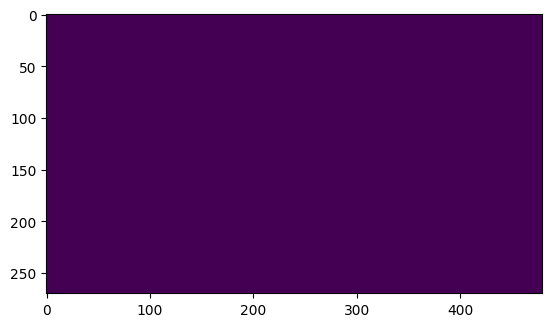

In [34]:
all_m = torch.zeros((1080//4, 1920//4), dtype = torch.bool).clone().detach()
all_m.shape
plt.imshow(all_m)

In [77]:
mask_list = []
mask_list2 = []
for frameid in tqdm(range(10,40,1)):
    # all_m = torch.zeros((args.IMAGE_HEIGHT,args.IMAGE_WIDTH), dtype = torch.bool).clone().detach()
    # frameid = i
    
    mask = torch.zeros((1080//4, 1920//4), dtype = torch.bool).clone().detach()
    
    of1 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=1', 'forward', f"{frameid:05d}.npy")))/1
    of_1 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=1', 'backward', f"{frameid:05d}.npy")))/-1
    of2 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=2', 'forward', f"{frameid:05d}.npy")))/2
    of_2 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=2', 'backward', f"{frameid:05d}.npy")))/-2
    of3 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=3', 'forward', f"{frameid:05d}.npy")))/3
    of_3 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=3', 'backward', f"{frameid:05d}.npy")))/-3
    of4 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=4', 'forward', f"{frameid:05d}.npy")))/4
    of_4 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=4', 'backward', f"{frameid:05d}.npy")))/-4
    of5 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=5', 'forward', f"{frameid:05d}.npy")))/5
    of_5 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=5', 'backward', f"{frameid:05d}.npy")))/-5
    
    of_list = [[of2,of_2], [of3,of_3], [of4,of_4], [of5,of_5], [of6,of_6], [of1, of_1, of2, of_2], [of2, of_2, of3, of_3], [of3, of_3, of4, of_4]]

    mask_temp_list = []
    error_list = []
    error_fusion = torch.zeros((1080//4, 1920//4))
    for ofs in of_list:

        of = torch.zeros_like(of1)
        for i in ofs:
            of = of + i
        of = of/len(ofs)
        # of = (ofs[0] + ofs[1])/2
        
        flow_test_np = of.permute(1,2,0).numpy().astype(np.float32)
        norm_flow = load_flow_tensor(flow_test_np)
        norm_flow = norm_flow.permute(1, 2, 0)
        uv = get_uv_grid(1080//4, 1920//4, align_corners=False)
        
        x1 = uv.reshape(-1, 2)
        x2 = x1 + norm_flow.view(-1, 2)
        F, _ = cv2.findFundamentalMat(x1.numpy(), x2.numpy(), cv2.FM_LMEDS)
        F = torch.from_numpy(F.astype(np.float32)) 
        err = compute_sampson_error(x1, x2, F).reshape(1080//4, 1920//4)
        norm_err = normalization(err)
        error_list.append(norm_err)
         
        mask_temp = norm_err>0.1
        mask_temp_list.append(mask_temp)
        mask = mask|mask_temp
    
    for j in error_list:
        error_fusion = error_fusion+ j
    error_fusion_norm = normalization(error_fusion)
    mask_list.append(mask)
    mask_list2.append(error_fusion_norm)

 70%|███████   | 21/30 [01:20<00:34,  3.83s/it]


FileNotFoundError: [Errno 2] No such file or directory: '/zfs/ailab/dehaoq/eccv2024/flow/Car_shadow_2.50/gap=9/forward/00031.npy'

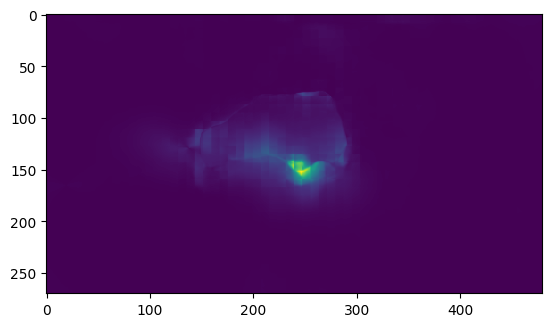

In [115]:
plt.imshow(mask_list2[7])

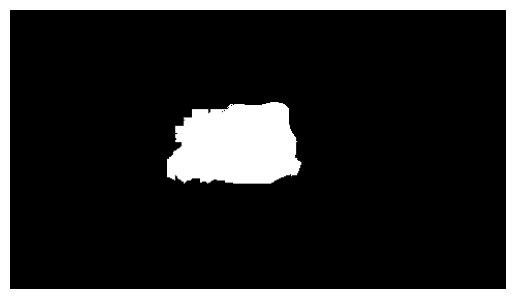

In [144]:
imgid = 20
plt.axis('off')
plt.imshow(mask_list2[imgid]**2>0.0005)
plt.imshow((mask_list2[imgid]**2>0.0005), cmap = 'gray')
plt.imsave(f'supp/sweep/2.5/{imgid:05d}.png', (mask_list2[imgid]**2>0.0005), cmap = 'gray')


(-0.5, 479.5, 269.5, -0.5)

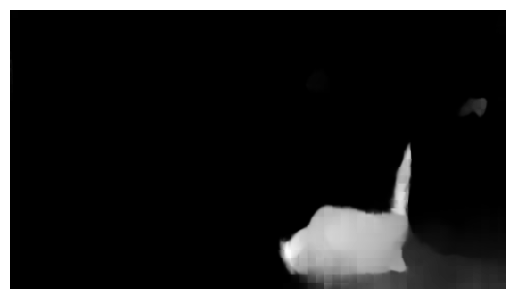

In [92]:
plt.imshow(error_list[0],cmap='gray')
plt.axis('off')

(-0.5, 479.5, 269.5, -0.5)

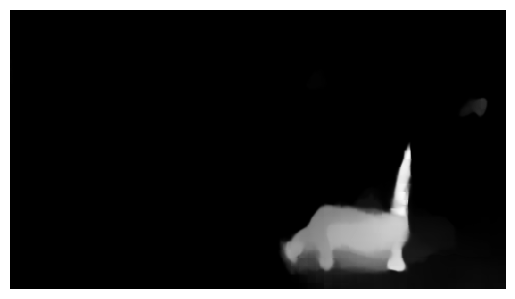

In [57]:
plt.imshow(mask_list2[0],cmap='gray')
plt.axis('off')

(-0.5, 479.5, 269.5, -0.5)

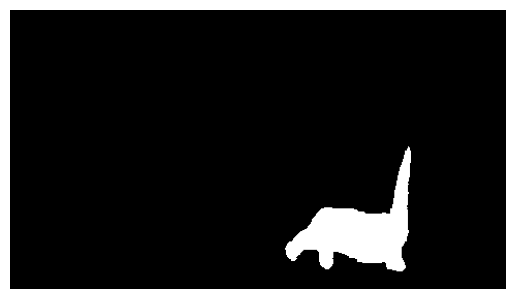

In [58]:
plt.imshow(mask_list2[0]>0.45,cmap='gray')
plt.axis('off')

In [76]:
for i in range(14,15,1):
    img_path = os.path.join(IMG_DIR, f"{i:05d}.png")
    image = Image.open(img_path).convert("RGB")
    image_resized = image.resize((1920//4, 1080//4))
    image_temp = np.array(image_resized)
    
    # image_temp = np.array(Image.open(img_path).convert("RGB"))
    # image_resized = image_temp.resize((1920//4, 1080//4))
    
    image_temp = torch.from_numpy(image_temp).permute(2,0,1).to(device='cpu')
    
    # mask_temp0 = torch.from_numpy(masks[0].numpy())
    # mask_temp0 = masks[i-4]
    # result0 = torchvision.utils.draw_segmentation_masks(torch.tensor((image_temp), dtype = torch.uint8), torch.tensor(mask_temp0, dtype = torch.bool), alpha=0.6, colors="yellow")
    # result0 = cv2.cvtColor(np.asarray(result0.permute(1,2,0)),cv2.COLOR_RGB2BGR) 
    # cv2.imwrite(os.path.join(Coarse_mask_with_frame, f"{i}.png"), result0)

In [86]:
import torchvision
result0 = torchvision.utils.draw_segmentation_masks(torch.tensor((image_temp), dtype = torch.uint8), torch.tensor(mask_list2[0]>0.45, dtype = torch.bool), alpha=0.6, colors="yellow")
# result0 = cv2.cvtColor(np.asarray(result0.permute(1,2,0)),cv2.COLOR_RGB2BGR) 
result0.shape

/local_scratch/pbs.2020922.pbs02/ipykernel_274318/1583399201.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result0 = torchvision.utils.draw_segmentation_masks(torch.tensor((image_temp), dtype = torch.uint8), torch.tensor(mask_list2[0]>0.45, dtype = torch.bool), alpha=0.6, colors="yellow")


torch.Size([3, 270, 480])

(-0.5, 479.5, 269.5, -0.5)

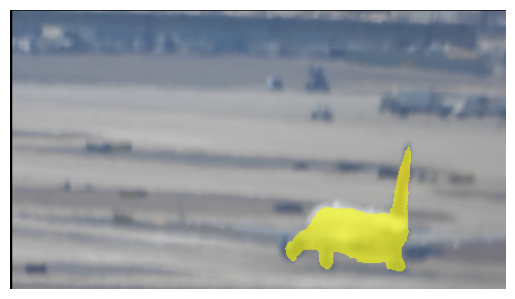

In [88]:
plt.imshow(result0.permute(1,2,0))
plt.axis('off')

In [54]:
norm_flow.shape

torch.Size([270, 480, 2])

In [ ]:
flows_forward = predictions_forward['flows'] # tensor 2*H*W
                flow_rgb_forward = flow_utils.flow_to_rgb(flows_forward)

In [55]:
flows_forward.shape

torch.Size([1, 1, 2, 270, 480])

In [60]:
of1.shape

torch.Size([2, 270, 480])

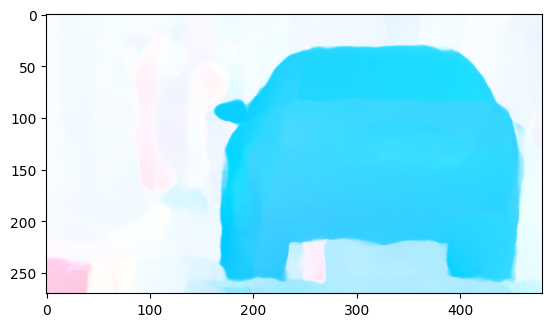

In [63]:
flow_rgb_forward = flow_utils.flow_to_rgb(of)
plt.imshow(flow_rgb_forward.permute(1,2,0))

In [64]:
flow_test_np = of.permute(1,2,0).numpy().astype(np.float32)
norm_flow = load_flow_tensor(flow_test_np)
norm_flow = norm_flow.permute(1, 2, 0)
uv = get_uv_grid(1080//4, 1920//4, align_corners=False)
        
x1 = uv.reshape(-1, 2)
x2 = x1 + norm_flow.view(-1, 2)
F, _ = cv2.findFundamentalMat(x1.numpy(), x2.numpy(), cv2.FM_LMEDS)
F = torch.from_numpy(F.astype(np.float32)) 

In [65]:
err = compute_sampson_error(x1, x2, F).reshape(1080//4, 1920//4)
# norm_err = normalization(err)
# error_list.append(norm_err)

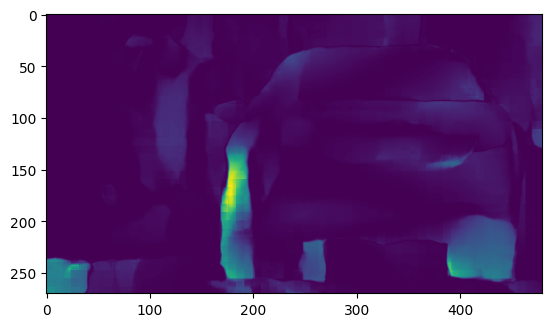

In [67]:
plt.imshow(err)

In [50]:
# of_list = [[of1,of_1], [of2,of_2], [of3,of_3], [of4,of_4], [of5,of_5]]
# of_list = [[of3,of_3]]
mask_list = []
for frameid in tqdm(range(30,31,1)):
    # all_m = torch.zeros((args.IMAGE_HEIGHT,args.IMAGE_WIDTH), dtype = torch.bool).clone().detach()
    # frameid = i
    
    mask = torch.zeros((1080//4, 1920//4), dtype = torch.bool).clone().detach()
    
    of1 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=1', 'forward', f"{frameid:05d}.npy")))/1
    of_1 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=1', 'backward', f"{frameid:05d}.npy")))/-1
    of2 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=2', 'forward', f"{frameid:05d}.npy")))/2
    of_2 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=2', 'backward', f"{frameid:05d}.npy")))/-2
    of3 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=3', 'forward', f"{frameid:05d}.npy")))/3
    of_3 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=3', 'backward', f"{frameid:05d}.npy")))/-3
    of4 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=4', 'forward', f"{frameid:05d}.npy")))/4
    of_4 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=4', 'backward', f"{frameid:05d}.npy")))/-4
    of5 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=5', 'forward', f"{frameid:05d}.npy")))/5
    of_5 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=5', 'backward', f"{frameid:05d}.npy")))/-5
    of6 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=6', 'forward', f"{frameid:05d}.npy")))/6
    of_6 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=6', 'backward', f"{frameid:05d}.npy")))/-6
    of7 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=7', 'forward', f"{frameid:05d}.npy")))/7
    of_7 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=7', 'backward', f"{frameid:05d}.npy")))/-7
    of8 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=8', 'forward', f"{frameid:05d}.npy")))/8
    of_8 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=8', 'backward', f"{frameid:05d}.npy")))/-8
    of9 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=9', 'forward', f"{frameid:05d}.npy")))/9
    of_9 = torch.from_numpy(np.load(os.path.join(FLOW_DIR, 'gap=9', 'backward', f"{frameid:05d}.npy")))/-9
    
    of_list = [[of1,of_1], [of2,of_2], [of3,of_3], [of4,of_4], [of5,of_5], [of6,of_6], [of1, of_1, of2, of_2], [of2, of_2, of3, of_3], [of3, of_3, of4, of_4]]
    # of_list = [[of6,of_6]]
    of_list = [[of1,of_1], [of2,of_2], [of3,of_3], [of4,of_4], [of5,of_5], [of6,of_6], [of7,of_7], [of8,of_8], [of9,of_9]]
    # of_list = [[of1,of_1], [of2,of_2], [of3,of_3], [of4,of_4], [of5,of_5]]
    # of_list = [[of1],[of_1], [of2],[of_2], [of3],[of_3], [of4],[of_4], [of5],[of_5], [of6],[of_6], [of7],[of_7], [of8],[of_8], [of9],[of_9]]
    of_list = [[of1,of_1,of2,of_2,of3,of_3], [of2,of_2,of3,of_3,of4,of_4], [of3,of_3,of4,of_4,of5,of_5], 
               [of4,of_4,of5,of_5,of6,of_6], [of5,of_5,of6,of_6,of7,of_7], [of6,of_6,of7,of_7,of8,of_8], 
               [of7,of_7,of8,of_8,of9,of_9], [of8,of_8,of9,of_9,of1,of_1], [of1,of_1,of9,of_9,of2,of_2]]
    # of_list = [[of1,of_1,of2,of_2,of3,of_3], [of2,of_2,of3,of_3,of4,of_4], [of3,of_3,of4,of_4,of5,of_5], 
    #            [of4,of_4,of5,of_5,of6,of_6], [of2,of_2,of4,of_4,of5,of_5], [of3,of_3,of4,of_4,of6,of_6]]
    
    mask_temp_list = []
    error_list = []
    for ofs in of_list:

        of = torch.zeros_like(of1)
        for i in ofs:
            of = of + i
        of = of/len(ofs)
        # of = (ofs[0] + ofs[1])/2
        
        flow_test_np = of.permute(1,2,0).numpy().astype(np.float32)
        norm_flow = load_flow_tensor(flow_test_np)
        norm_flow = norm_flow.permute(1, 2, 0)
        uv = get_uv_grid(1080//4, 1920//4, align_corners=False)
        
        x1 = uv.reshape(-1, 2)
        x2 = x1 + norm_flow.view(-1, 2)
        F, _ = cv2.findFundamentalMat(x1.numpy(), x2.numpy(), cv2.FM_LMEDS)
        F = torch.from_numpy(F.astype(np.float32)) 
        err = compute_sampson_error(x1, x2, F).reshape(1080//4, 1920//4)
        norm_err = normalization(err)
        error_list.append(norm_err)
        mask_temp = norm_err>0.1
        mask_temp_list.append(mask_temp)
        mask = mask|mask_temp
        
    mask_list.append(mask)

100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


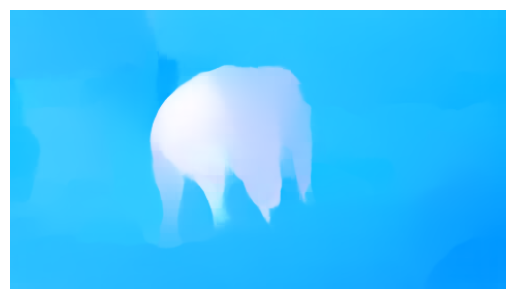

In [79]:
flow_rgb_forward = flow_utils.flow_to_rgb((of_2))
plt.axis('off')
plt.imshow(flow_rgb_forward.permute(1,2,0))

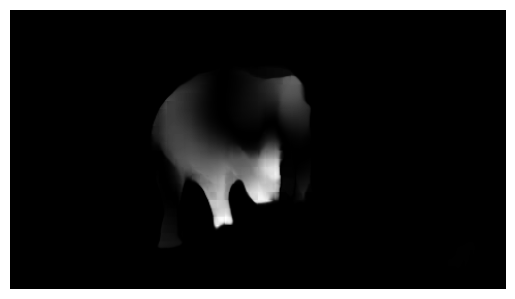

In [82]:
plt.axis('off')
plt.imshow(error_list[3],cmap='gray')

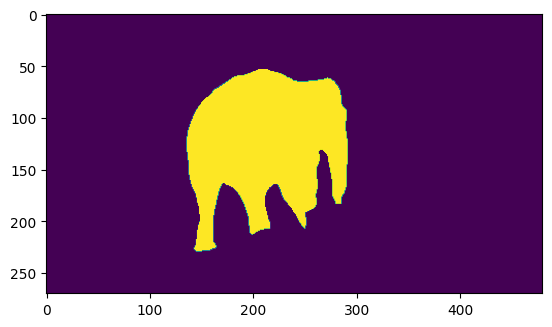

In [52]:
plt.imshow(mask_list[-1])

In [53]:
plt.imshow(mask_list[12])

IndexError: list index out of range

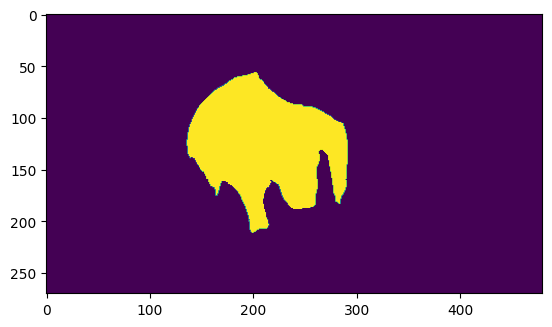

In [54]:
plt.imshow(mask_temp_list[1])

In [58]:
for i in range(30,31,1):
    img_path = os.path.join(IMG_DIR,'Frames', f"{i:05d}.jpg")
    image = Image.open(img_path).convert("RGB")
    image_resized = image.resize((1920//4, 1080//4))
    image_temp = np.array(image_resized)
    
    # image_temp = np.array(Image.open(img_path).convert("RGB"))
    # image_resized = image_temp.resize((1920//4, 1080//4))
    
    image_temp = torch.from_numpy(image_temp).permute(2,0,1).to(device='cpu')
    
    # mask_temp0 = torch.from_numpy(masks[0].numpy())
    # mask_temp0 = masks[i-4]
    # result0 = torchvision.utils.draw_segmentation_masks(torch.tensor((image_temp), dtype = torch.uint8), torch.tensor(mask_temp0, dtype = torch.bool), alpha=0.6, colors="yellow")
    # result0 = cv2.cvtColor(np.asarray(result0.permute(1,2,0)),cv2.COLOR_RGB2BGR) 
    # cv2.imwrite(os.path.join(Coarse_mask_with_frame, f"{i}.png"), result0)

In [60]:
import torchvision

In [62]:
result0 = torchvision.utils.draw_segmentation_masks(torch.tensor((image_temp), dtype = torch.uint8), torch.tensor(mask_list[0], dtype = torch.bool), alpha=0.6, colors="yellow")
result0 = cv2.cvtColor(np.asarray(result0.permute(1,2,0)),cv2.COLOR_RGB2BGR) 

/local_scratch/pbs.1976501.pbs02/ipykernel_738392/196951085.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result0 = torchvision.utils.draw_segmentation_masks(torch.tensor((image_temp), dtype = torch.uint8), torch.tensor(mask_list[0], dtype = torch.bool), alpha=0.6, colors="yellow")


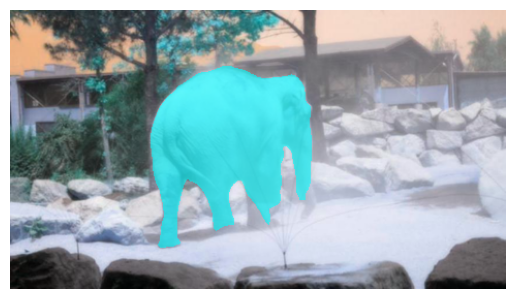

In [64]:
plt.axis('off')
plt.imshow(result0)

In [123]:
of[0]

tensor([[-2.0096, -2.0132, -2.0150,  ..., -2.2863, -2.2897, -2.2927],
        [-2.0098, -2.0113, -2.0126,  ..., -2.2878, -2.2908, -2.2941],
        [-2.0102, -2.0113, -2.0124,  ..., -2.2894, -2.2901, -2.2937],
        ...,
        [-2.0997, -2.1020, -2.1012,  ..., -2.3654, -2.3651, -2.3629],
        [-2.0994, -2.1004, -2.0996,  ..., -2.3681, -2.3665, -2.3652],
        [-2.0988, -2.0991, -2.0982,  ..., -2.3706, -2.3695, -2.3680]])

In [124]:
of1[0]

tensor([[-2.3852, -2.3874, -2.3880,  ..., -2.3205, -2.3266, -2.3336],
        [-2.3868, -2.3877, -2.3877,  ..., -2.3206, -2.3259, -2.3326],
        [-2.3881, -2.3886, -2.3887,  ..., -2.3225, -2.3239, -2.3309],
        ...,
        [-2.9217, -2.9237, -2.9232,  ..., -2.6615, -2.6580, -2.6527],
        [-2.9212, -2.9216, -2.9212,  ..., -2.6643, -2.6612, -2.6561],
        [-2.9203, -2.9202, -2.9196,  ..., -2.6660, -2.6621, -2.6578]])

In [340]:
of = (of3+of_3+of4+of_4+of_5+of5)/6

In [321]:
of = (of4+of_4)/2

In [341]:
of.shape

torch.Size([2, 270, 480])

In [342]:
flow_test_np = of.permute(1,2,0).numpy().astype(np.float32)

In [343]:
norm_flow = load_flow_tensor(flow_test_np)
# flow_test_np = flow_test.cpu().numpy().astype(np.float32)
flow_test_np.shape

(270, 480, 2)

In [344]:
norm_flow = load_flow_tensor(flow_test_np)
norm_flow = norm_flow.permute(1, 2, 0)
norm_flow.shape

torch.Size([270, 480, 2])

In [345]:
uv = get_uv_grid(1080//4, 1920//4, align_corners=False)
x1 = uv.reshape(-1, 2)
x2 = x1 + norm_flow.view(-1, 2)
F, _ = cv2.findFundamentalMat(x1.numpy(), x2.numpy(), cv2.FM_LMEDS)
F

array([[-3.76493957e-02,  6.02028330e+01,  1.07080282e+02],
       [-6.01548208e+01,  8.46136633e-03,  9.38359360e+01],
       [-1.07043079e+02, -9.33521254e+01,  1.00000000e+00]])

In [346]:
F = torch.from_numpy(F.astype(np.float32)) 
err = compute_sampson_error(x1, x2, F).reshape(1080//4, 1920//4)
err_norm = normalization(err)

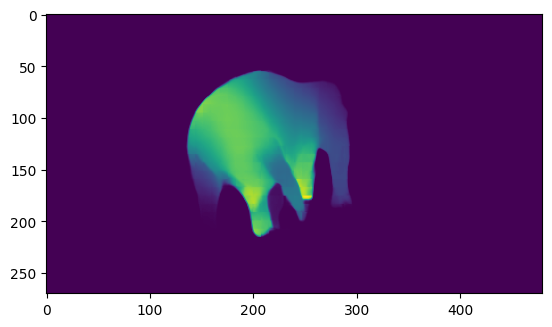

In [347]:
plt.imshow(err_norm)

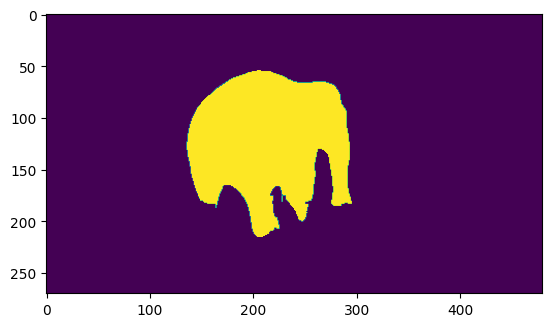

In [348]:
plt.imshow(err_norm>0.05)

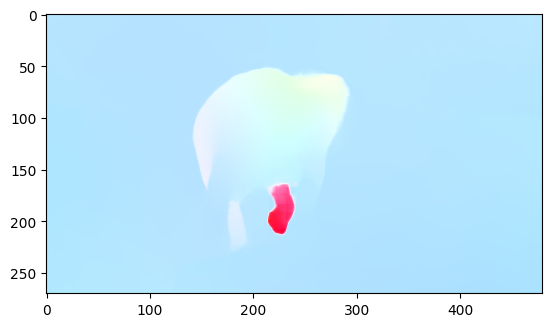

In [166]:
plt.imshow(flow_rgb_forward.squeeze().permute(1,2,0).cpu())

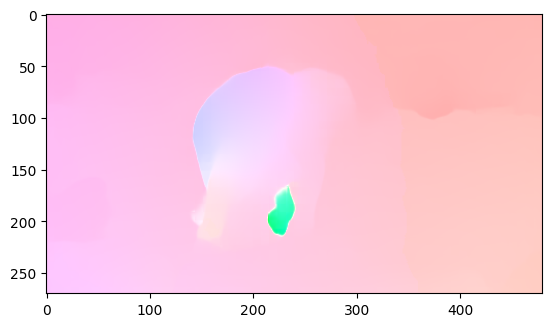

In [167]:
plt.imshow(flow_rgb_backward.squeeze().permute(1,2,0).cpu())

In [136]:
flows_forward.shape

torch.Size([1, 1, 2, 270, 480])

In [137]:
flow_test = flows_forward.squeeze().permute(1,2,0)

In [138]:
flow_test_np = flow_test.cpu().numpy().astype(np.float32)

In [139]:
flow_test_np.shape

(270, 480, 2)

In [140]:
def load_flow_tensor(flow, scale=1, normalize=True, align_corners=True):
    """
    Load flow, scale the pixel values according to the resized scale.
    If normalize is true, return rescaled in normalized pixel coordinates
    where pixel coordinates are in range [-1, 1].
    NOTE: RAFT USES ALIGN_CORNERS=TRUE SO WE NEED TO ACCOUNT FOR THIS
    Returns (2, H, W) float32
    """
    # flow = read_flo(path).astype(np.float32)
    H, W, _ = flow.shape
    u, v = flow[..., 0], flow[..., 1]
    if normalize:
        if align_corners:
            u = 2.0 * u / (W - 1)
            v = 2.0 * v / (H - 1)
        else:
            u = 2.0 * u / W
            v = 2.0 * v / H
    else:
        u = scale * u
        v = scale * v

    if scale != 1:
        h, w = int(scale * H), int(scale * W)
        u = Image.fromarray(u).resize((w, h), Image.ANTIALIAS)
        v = Image.fromarray(v).resize((w, h), Image.ANTIALIAS)
        u, v = np.array(u), np.array(v)
    return torch.from_numpy(np.stack([u, v], axis=0))

In [141]:
norm_flow = load_flow_tensor(flow_test_np)

In [142]:
norm_flow = norm_flow.permute(1, 2, 0)

In [143]:
norm_flow.shape

torch.Size([270, 480, 2])

In [144]:
def get_uv_grid(H, W, homo=False, align_corners=False, device=None):
    """
    Get uv grid renormalized from -1 to 1
    :returns (H, W, 2) tensor
    """
    if device is None:
        device = torch.device("cpu")
    yy, xx = torch.meshgrid(
        torch.arange(H, dtype=torch.float32, device=device),
        torch.arange(W, dtype=torch.float32, device=device),
        indexing="ij",
    )
    if align_corners:
        xx = 2 * xx / (W - 1) - 1
        yy = 2 * yy / (H - 1) - 1
    else:
        xx = 2 * (xx + 0.5) / W - 1
        yy = 2 * (yy + 0.5) / H - 1
    if homo:
        return torch.stack([xx, yy, torch.ones_like(xx)], dim=-1)
    return torch.stack([xx, yy], dim=-1)

def compute_sampson_error(x1, x2, F):
    """
    :param x1 (*, N, 2)
    :param x2 (*, N, 2)
    :param F (*, 3, 3)
    """
    h1 = torch.cat([x1, torch.ones_like(x1[..., :1])], dim=-1)
    h2 = torch.cat([x2, torch.ones_like(x2[..., :1])], dim=-1)
    d1 = torch.matmul(h1, F.transpose(-1, -2))  # (B, N, 3)
    d2 = torch.matmul(h2, F)  # (B, N, 3)
    z = (h2 * d1).sum(dim=-1)  # (B, N)
    err = z ** 2 / (
        d1[..., 0] ** 2 + d1[..., 1] ** 2 + d2[..., 0] ** 2 + d2[..., 1] ** 2
    )
    return err

In [145]:
uv = get_uv_grid(1080//4, 1920//4, align_corners=False)

In [146]:
x1 = uv.reshape(-1, 2)
x2 = x1 + norm_flow.view(-1, 2)

In [147]:
F, _ = cv2.findFundamentalMat(x1.numpy(), x2.numpy(), cv2.FM_LMEDS)
F

array([[ 9.47083993e-02,  3.10631771e+00,  2.91789839e+01],
       [-3.04071826e+00,  4.37276088e-03,  3.72803201e+00],
       [-2.91787000e+01, -3.64549228e+00,  1.00000000e+00]])

In [148]:
F = torch.from_numpy(F.astype(np.float32)) 
err = compute_sampson_error(x1, x2, F).reshape(1080//4, 1920//4)

In [149]:
err_norm = normalization(err)

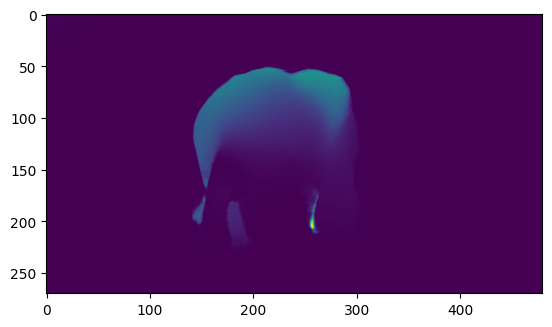

In [150]:
plt.imshow(err_norm)

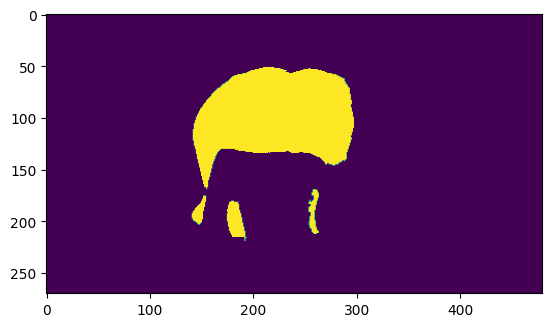

In [152]:
plt.imshow(err_norm>0.05)

In [91]:
err_norm[:8,:8]

tensor([[    0.0001,     0.0001,     0.0001,     0.0001,     0.0001,     0.0001,
             0.0001,     0.0001],
        [    0.0001,     0.0001,     0.0001,     0.0001,     0.0001,     0.0001,
             0.0001,     0.0001],
        [    0.0001,     0.0001,     0.0001,     0.0001,     0.0001,     0.0001,
             0.0001,     0.0001],
        [    0.0001,     0.0001,     0.0001,     0.0001,     0.0001,     0.0001,
             0.0001,     0.0001],
        [    0.0001,     0.0001,     0.0001,     0.0001,     0.0001,     0.0001,
             0.0001,     0.0001],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0001,     0.0001,
             0.0001,     0.0001],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0001,
             0.0001,     0.0001],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0001]])

In [92]:
err_norm[150:158,100:108]

tensor([[    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000]])

In [70]:
img0 = cv2.imread(os.path.join(IMG_DIR, f"{30:05d}.png"))
img0 = cv2.resize(img0, (1920//4, 1080//4), interpolation = cv2.INTER_AREA)
img2 = cv2.imread(os.path.join(IMG_DIR, f"{26:05d}.png"))
img2 = cv2.resize(img2, (1920//4, 1080//4), interpolation = cv2.INTER_AREA)

In [71]:
img0t = torch.from_numpy(img0).permute(2,0,1)
img2t = torch.from_numpy(img2).permute(2,0,1)

In [72]:
images = [img0t.squeeze(0).permute(1,2,0).cpu().numpy(),
          img2t.squeeze(0).permute(1,2,0).cpu().numpy(),]

In [73]:
model = ptlflow.get_model('gma',pretrained_ckpt='sintel')
model = model.to(device)
io_adapter = IOAdapter(model, images[0].shape[:2])


In [74]:
inputs = io_adapter.prepare_inputs(images)
inputs['images'] = inputs['images'].to(device)

In [75]:
with torch.no_grad():

    predictions = model(inputs)
    predictions = io_adapter.unpad_and_unscale(predictions)
    flows = predictions['flows']
    flow_rgb = flow_utils.flow_to_rgb(flows)
#     flow_rgb = flow_rgb[0, 0].permute(1, 2, 0)
#     flow_rgb_npy = flow_rgb.detach().cpu().numpy()*255

#     RGB = np.uint8(flow_rgb_npy)

In [76]:
flow_rgb.squeeze().shape

torch.Size([3, 270, 480])

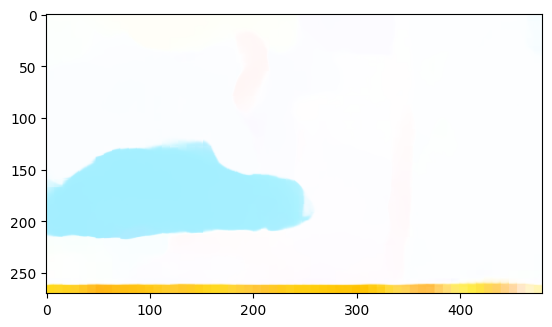

In [77]:
plt.imshow(flow_rgb.squeeze().permute(1,2,0).cpu())

In [109]:
img0 = cv2.imread(os.path.join(IMG_DIR, f"{30:05d}.png"))
img0 = cv2.resize(img0, (1920//6, 1080//6), interpolation = cv2.INTER_AREA)
img2 = cv2.imread(os.path.join(IMG_DIR, f"{32:05d}.png"))
img2 = cv2.resize(img2, (1920//6, 1080//6), interpolation = cv2.INTER_AREA)

img0t = torch.from_numpy(img0).permute(2,0,1)
img2t = torch.from_numpy(img2).permute(2,0,1)

images = [img0t.squeeze(0).permute(1,2,0).cpu().numpy(),
          img2t.squeeze(0).permute(1,2,0).cpu().numpy(),]

model = ptlflow.get_model('gma',pretrained_ckpt='sintel')
model = model.to(device)
io_adapter = IOAdapter(model, images[0].shape[:2])


inputs = io_adapter.prepare_inputs(images)
inputs['images'] = inputs['images'].to(device)

with torch.no_grad():

    predictions = model(inputs)
    predictions = io_adapter.unpad_and_unscale(predictions)
    flows = predictions['flows']
    flow_rgb = flow_utils.flow_to_rgb(flows)


In [110]:
# flows = flows1-flows2

In [111]:
# flows = flows1 + flows2/2 + flows3/3 + flows4/4

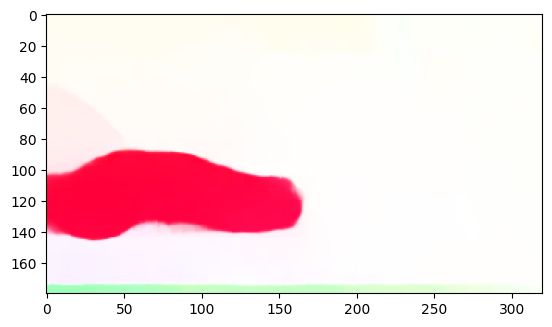

In [112]:
plt.imshow(flow_rgb.squeeze().permute(1,2,0).cpu())

In [113]:
# flows = flows0+flows1/2+flows2/3

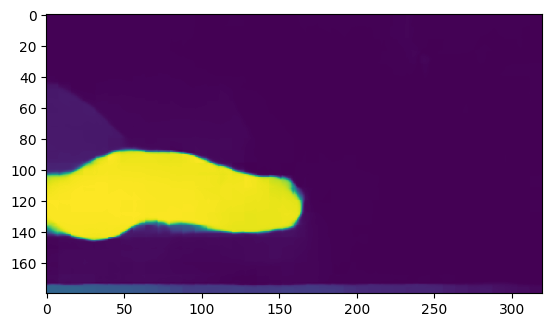

In [114]:
flows_temp = flows.squeeze().clone().cpu()
flows_temp = torch.abs(flows_temp[0,:,:])
flows_temp = normalization(flows_temp)
# flows_temp = flows_temp[flows_temp>0.2]
flows_temp.shape
plt.imshow(flows_temp)

In [115]:
mask = flows_temp > 0.3

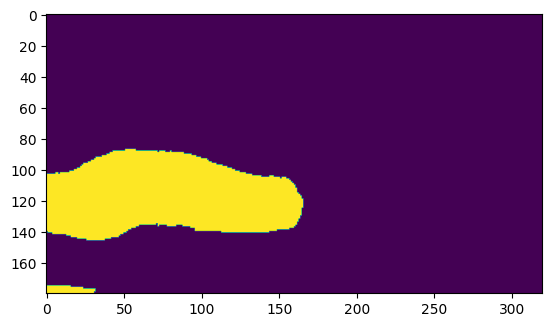

In [116]:
plt.imshow(mask)

In [117]:
flows.squeeze()[1,100,250]

tensor(0.0630, device='cuda:0')

In [135]:
def get_uv_grid(H, W, homo=False, align_corners=False, device=None):
    """
    Get uv grid renormalized from -1 to 1
    :returns (H, W, 2) tensor
    """
    if device is None:
        device = torch.device("cpu")
    yy, xx = torch.meshgrid(
        torch.arange(H, dtype=torch.float32, device=device),
        torch.arange(W, dtype=torch.float32, device=device),
        indexing="ij",
    )
    if align_corners:
        xx = 2 * xx / (W - 1) - 1
        yy = 2 * yy / (H - 1) - 1
    else:
        xx = 2 * (xx + 0.5) / W - 1
        yy = 2 * (yy + 0.5) / H - 1
    if homo:
        return torch.stack([xx, yy, torch.ones_like(xx)], dim=-1)
    return torch.stack([xx, yy], dim=-1)

def compute_sampson_error(x1, x2, F):
    """
    :param x1 (*, N, 2)
    :param x2 (*, N, 2)
    :param F (*, 3, 3)
    """
    h1 = torch.cat([x1, torch.ones_like(x1[..., :1])], dim=-1)
    h2 = torch.cat([x2, torch.ones_like(x2[..., :1])], dim=-1)
    d1 = torch.matmul(h1, F.transpose(-1, -2))  # (B, N, 3)
    d2 = torch.matmul(h2, F)  # (B, N, 3)
    z = (h2 * d1).sum(dim=-1)  # (B, N)
    err = z ** 2 / (
        d1[..., 0] ** 2 + d1[..., 1] ** 2 + d2[..., 0] ** 2 + d2[..., 1] ** 2
    )
    return err

In [136]:
# p = get_uv_grid(1920//4, 1080//4)
p = get_uv_grid(1080//6, 1920//6)
x1= p.reshape(-1,2)

In [137]:
x1

tensor([[-0.9969, -0.9944],
        [-0.9906, -0.9944],
        [-0.9844, -0.9944],
        ...,
        [ 0.9844,  0.9944],
        [ 0.9906,  0.9944],
        [ 0.9969,  0.9944]])

In [138]:
flow

tensor([[[ 0.0717,  0.5173],
         [ 0.0699,  0.5188],
         [ 0.0682,  0.5150],
         ...,
         [-0.0346,  0.2808],
         [-0.0382,  0.2881],
         [-0.0368,  0.2909]],

        [[ 0.0716,  0.5179],
         [ 0.0701,  0.5165],
         [ 0.0688,  0.5130],
         ...,
         [-0.0339,  0.2826],
         [-0.0365,  0.2895],
         [-0.0366,  0.2946]],

        [[ 0.0703,  0.5169],
         [ 0.0698,  0.5160],
         [ 0.0684,  0.5132],
         ...,
         [-0.0336,  0.2828],
         [-0.0354,  0.2881],
         [-0.0359,  0.2939]],

        ...,

        [[-3.4064,  2.0948],
         [-3.4043,  2.0898],
         [-3.4094,  2.0930],
         ...,
         [-0.2203,  0.3924],
         [-0.2140,  0.3836],
         [-0.2184,  0.3735]],

        [[-3.3831,  2.0767],
         [-3.3846,  2.0745],
         [-3.3933,  2.0796],
         ...,
         [-0.2252,  0.3954],
         [-0.2188,  0.3891],
         [-0.2299,  0.3833]],

        [[-3.3750,  2.0704],
       

In [120]:
p.shape

torch.Size([180, 320, 2])

In [121]:
x1.shape

torch.Size([57600, 2])

In [122]:
flows.squeeze().shape

torch.Size([2, 180, 320])

In [123]:
flow = flows.squeeze().permute(1,2,0).cpu()

In [124]:
# flow = flow[:270,:400,:]
# p = get_uv_grid(1080//4, 400)
# x1= p.reshape(-1,2)

In [125]:
flow.shape

torch.Size([180, 320, 2])

In [126]:
x1.shape

torch.Size([57600, 2])

In [127]:
mask.shape

torch.Size([180, 320])

In [128]:
flow.shape

torch.Size([180, 320, 2])

In [129]:
mask = mask.reshape(180,320,1)
mask2 = mask.repeat(1,1,2)
mask2.shape

torch.Size([180, 320, 2])

In [130]:
# x2 = x1 + flow.view(-1, 2)
# x2 = x1 + flow.reshape(-1, 2)
x2 = x1 + (~mask*flow).reshape(-1, 2)
x22 = x1 + flow.reshape(-1, 2)
# F, _ = cv2.findFundamentalMat(x1.numpy(), (mask2.reshape(-1, 2)*x2).numpy(), cv2.FM_LMEDS)
F, _ = cv2.findFundamentalMat(x1.numpy(), x22.numpy(), cv2.FM_LMEDS)
F = torch.from_numpy(F.astype(np.float32))
err = compute_sampson_error(x1, x22, F).reshape(1080//6, 1920//6)
# err = compute_sampson_error(x1, x2, F).reshape(1080//4, 400)
err = normalization(err)
# err = torch.where(err <= 0.3, torch.zeros_like(err), err)
# err_f = torch.tensor(err, dtype = torch.bool)
# all_m = all_m | err_f
# plt.imshow(all_m)
# plt.axis("off")
# plt.show()

In [131]:
F

tensor([[  0.7930,  -2.9593, -15.7838],
        [  2.1804,   0.0291,  -1.1734],
        [ 13.6966,   1.8016,   1.0000]])

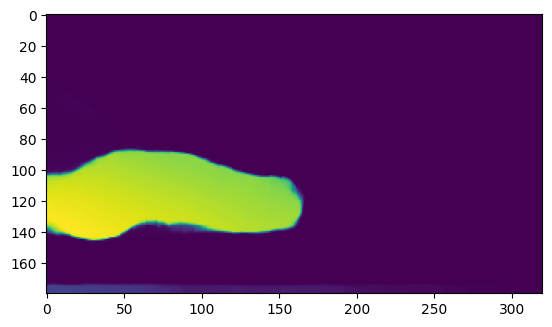

In [132]:
plt.imshow(err)

In [133]:
err

tensor([[    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0001,
             0.0001],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0001,
             0.0001],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        ...,
        [    0.2053,     0.2053,     0.2058,  ...,     0.0011,     0.0010,
             0.0011],
        [    0.2038,     0.2041,     0.2049,  ...,     0.0012,     0.0011,
             0.0012],
        [    0.2035,     0.2039,     0.2050,  ...,     0.0012,     0.0012,
             0.0013]])

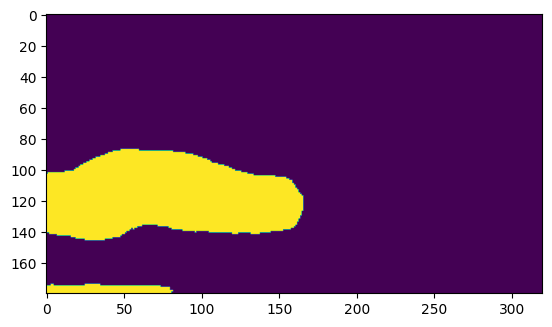

In [134]:
plt.imshow(err>0.1)

In [180]:
err[100,150]

tensor(0.6917)

In [181]:
mask2.reshape(-1, 2)*x2

tensor([[-0., -0.],
        [-0., -0.],
        [-0., -0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [182]:
x2

tensor([[-1.0461, -0.9515],
        [-1.0424, -0.9510],
        [-1.0367, -0.9513],
        ...,
        [ 1.0104,  0.8684],
        [ 1.0170,  0.8685],
        [ 1.0228,  0.8679]])

In [74]:
flows.shape

torch.Size([1, 1, 2, 480, 270])

In [75]:
flow_rgb.shape

torch.Size([480, 270, 3])

In [76]:
flow_rgb.shape

torch.Size([480, 270, 3])

In [77]:
flow_rgb_npy.shape

(480, 270, 3)

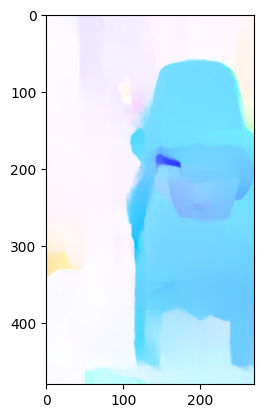

In [78]:
plt.imshow(RGB)

In [ ]:
# Get each frame

video_img_np = []
video_img_ts = []
j = 0
for i in range(0, NUM_FRAME, 1):
    img_id = f"{i}.jpg"
    frame = os.path.join(IMG_DIR, img_id)
    video_img_np.append(cv2.imread(frame)[:,:,::-1].copy())
    video_img_ts.append(torch.from_numpy(cv2.imread(frame)[:,:,::-1].copy()).permute(2,0,1))
    # print(f"Get {img_id} with RGD")
    # plt.imshow(DSCN2630_MStab_300_img_np[j])
    # plt.show()
    j = j+1
print(video_img_ts[0].shape)
print(len(video_img_ts))